# 1. Imports 

In [1]:
import keras
import autokeras as ak
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


# constants
#path = 'C:/Users/monte/Documents/Memoria/src'
path = 'C:/Users/asus/Documents/2023_2/Memoria/src'


# seeds
global_seed = 19
# np.random.seed(seed=global_seed) # seed gets seted by statement below
keras.utils.set_random_seed(global_seed)
tf.config.experimental.enable_op_determinism()


# Ostar
O_df = pd.read_csv(path+'/Data/o_spectral_lines.csv')
# Bstar
B_df = pd.read_csv(path+'/Data/b_spectral_lines.csv')
# Observed spectra
Obs_df = pd.read_csv(path+'/Data/observed_spectral_lines_v3.csv')

Using TensorFlow backend


# 2. Data

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

target = ['temperature','g','v']


X = B_df.drop(target,axis = 1)
Y = B_df[target]
x_obs = Obs_df.drop(target+['HD','date','time'],axis=1)
Y_obs = Obs_df[target]

y_scaler = MinMaxScaler()
x_scaler = MinMaxScaler()

x_train, x_val, y_train, y_val = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=global_seed)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, train_size=0.75, test_size=0.25, random_state=global_seed)

#x_train = np.random.normal(loc=0, scale=0.01, size=x_train.shape) + x_train

y_scaler = y_scaler.fit(y_train)
y_train = y_scaler.transform(y_train)
y_val = y_scaler.transform(y_val)
y_test = y_scaler.transform(y_test)
y_obs = y_scaler.transform(Y_obs.values)

# x_scaler = x_scaler.fit(x_train)
# x_train = x_scaler.transform(x_train)
# x_val = x_scaler.transform(x_val)
# x_test = x_scaler.transform(x_test)
# x_obs = x_scaler.transform(X_obs.values)



c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [3]:
# Density plot function

# https://kdepy.readthedocs.io/en/latest/examples.html#minimal-working-example-with-options
from KDEpy import FFTKDE
from sklearn.neighbors import KernelDensity
import numpy as np

measure = ['Temperature','log g', 'v sini']
measure_unit = ['[K]', '[1]', '[km/s]']

def SKL_density_plot(data, ax,low_bound=None,up_bound=None,title='', color='black',alpha=1,label='',kernel='gaussian', bw='silverman',linewidth=1):
  
	if low_bound != None and up_bound != None:
		bw = FFTKDE(bw=bw, kernel='gaussian').fit(data).bw
		kde = KernelDensity(bandwidth=bw, kernel=kernel).fit(data.reshape(-1,1))
		data = np.concatenate((data, 2 * low_bound - data, 2 * up_bound - data))
		kde = KernelDensity(bandwidth=kde.bandwidth_, kernel=kernel).fit(data.reshape(-1,1))
		x = np.linspace(low_bound,up_bound,1000)
		y = np.exp(kde.score_samples(x.reshape(-1,1)))
		plot_y = y[np.where((x>=low_bound) & (x<=up_bound))] # Set the KDE to zero outside of the domain
		plot_x = x[np.where((x>=low_bound) & (x<=up_bound))]  # Set the KDE to zero outside of the domain
		plot_y = plot_y * 3  # Double the y-values to get integral of ~1
		ax.plot(plot_x, plot_y, label=label,color=color,alpha=alpha,linewidth=linewidth)
		return x, y, kde
	else:
		kde = KernelDensity(bandwidth=bw, kernel=kernel).fit(data.reshape(-1,1))
		x=np.linspace(data.min(),data.max(),1000)
		y = np.exp(kde.score_samples(x.reshape(-1,1)))
		ax.plot(x, y, label=label,color=color,alpha=alpha)
		return x, y, kde

# 3. NN Training

In [4]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers 

#input_shape = (4, 10, 128) = (batch_size, steps, vectorLength) = (batchsize, rotaciones, frecuencias)

#normalize = layers.Normalization()

# This layer will shift and scale inputs into a distribution centered around 0 with standard deviation 1.
# It accomplishes this by precomputing the mean and variance of the data and calling (input - mean) / sqrt(var) at runtime

# TODO: Probar con los datos sin normalizar
#normalize.adapt(x_train)

input_shape = (x_train.shape[1],1)

def generate_model(): 
  return tf.keras.Sequential([
  keras.Input(shape=(input_shape)),
  #normalize,
  layers.Conv1D(32,padding="same",kernel_size=3, activation='relu'),
  layers.Conv1D(32,padding="same",kernel_size=3, activation='relu'),
  layers.Conv1D(32,padding="same",kernel_size=3, activation='relu'),
  layers.MaxPooling1D(pool_size=3, padding='same'),
  layers.Conv1D(64,padding="same",kernel_size=2, activation='relu'),
  layers.Conv1D(64,padding="same",kernel_size=2, activation='relu'),
  layers.Conv1D(64,padding="same",kernel_size=2, activation='relu'),
  layers.MaxPooling1D(pool_size=2, padding='same'),
  layers.Conv1D(128,padding="same",kernel_size=2, activation='relu'),
  layers.Conv1D(128,padding="same",kernel_size=2, activation='relu'),
  layers.Conv1D(128,padding="same",kernel_size=2, activation='relu'),
  layers.MaxPooling1D(pool_size=2, padding='same'),
  layers.GlobalAveragePooling1D(),
  
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(3, activation='linear')
])

In [5]:
model = generate_model()
model = tf.keras.Model(inputs=model.input, outputs=model.output) 
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 701, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 701, 32)           128       
                                                                 
 conv1d_1 (Conv1D)           (None, 701, 32)           3104      
                                                                 
 conv1d_2 (Conv1D)           (None, 701, 32)           3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 234, 32)          0         
 )                                                               
                                                                 
 conv1d_3 (Conv1D)           (None, 234, 64)           4160      
                                                             

In [6]:
model.compile(loss = ['MSE'],
                           optimizer = tf.optimizers.Adam(),
                           metrics=['MAE'])

# model.compile(loss='MAE',optimizer=optimizer,metrics=['MSE'])
#history = simple_model.fit(x=x_train, y=y_train, validation_data=(x_val,y_val), epochs=20)

history = model.fit(x=x_train, y=y_train,validation_data=(x_val,y_val), epochs=30)

Epoch 1/30
459/459 [==============================] - 12s 13ms/step - loss: 0.0864 - MAE: 0.2505 - val_loss: 0.0825 - val_MAE: 0.2454
Epoch 2/30
459/459 [==============================] - 5s 12ms/step - loss: 0.0827 - MAE: 0.2471 - val_loss: 0.0826 - val_MAE: 0.2463
Epoch 3/30
459/459 [==============================] - 5s 12ms/step - loss: 0.0824 - MAE: 0.2468 - val_loss: 0.0820 - val_MAE: 0.2449
Epoch 4/30
294/459 [==================>...........] - ETA: 1s - loss: 0.0825 - MAE: 0.2469

KeyboardInterrupt: 

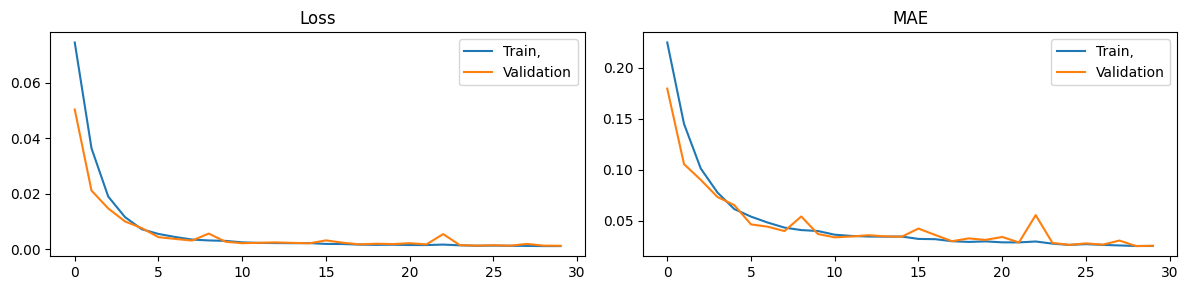

In [ ]:
fig, axis = plt.subplots(1, 2, figsize=(12,3))
# trendlines
axis[0].plot(history.history['loss'], label='train t_out_loss')
axis[1].plot(history.history['MAE'], label='val  t_out_loss')
axis[0].plot(history.history['val_loss'], label='train t_out_accuracy')
axis[1].plot(history.history['val_MAE'], label='val t_out_accuracy')

# titles
axis[0].set_title("Loss")
axis[1].set_title("MAE")

# legends
axis[0].legend(['Train,','Validation'])
axis[1].legend(['Train,','Validation'])

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the best model with testing data.
evaluation = model.evaluate(x_test, y_test)

print('loss: %.4f  MAE:%.4f'% (evaluation[0],evaluation[1]))

153/153 [==============================] - 1s 5ms/step - loss: 0.0013 - MAE: 0.0252
loss: 0.0013  MAE:0.0252


In [ ]:
predictions = model.predict(x_test)

153/153 [==============================] - 1s 3ms/step


In [ ]:
losses = []
maes = []

for i in range(len(target)):
  losses.append(np.mean((predictions[:,i]-y_test[:,i])**2))
  maes.append(np.mean(np.abs(predictions[:,i]-y_test[:,i])))
  
print('Temperatura - loss: %.4f  MAE:%.4f'% (losses[0],maes[0]))
print('log g -       loss: %.4f  MAE:%.4f'% (losses[1],maes[1]))
print('v -           loss: %.4f  MAE:%.4f'% (losses[2],maes[2]))


Temperatura - loss: 0.0021  MAE:0.0334
log g -       loss: 0.0010  MAE:0.0223
v -           loss: 0.0007  MAE:0.0201


In [ ]:
predictions = y_scaler.inverse_transform(predictions)

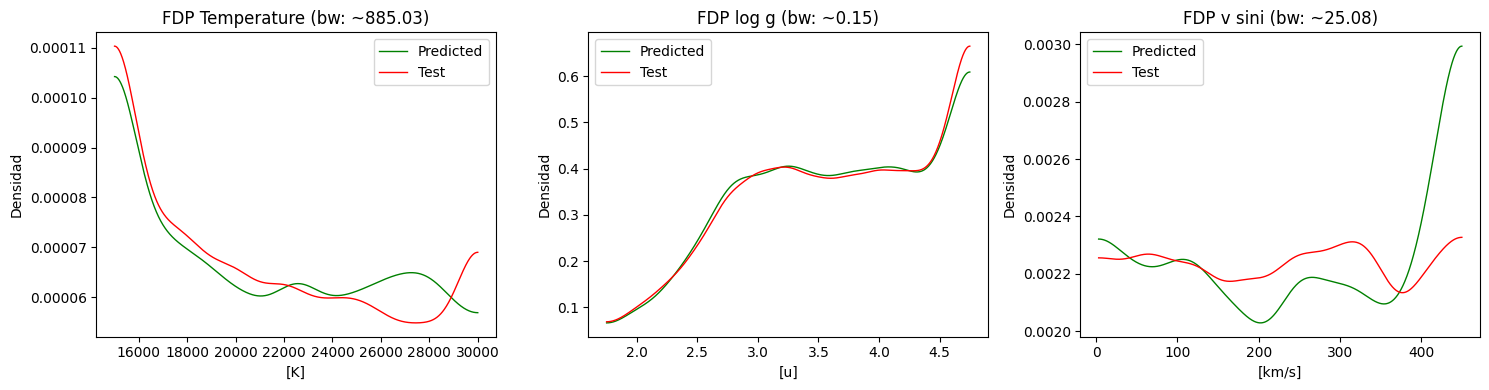

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))

for i, featureName in enumerate(target):
	x, y, kde = SKL_density_plot(predictions[:,i], axes[i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color = 'green',label='Single CNN Prediction')
	x, y, kde = SKL_density_plot(y_scaler.inverse_transform(y_test)[:,i], axes[i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color='red',label='Test')
	axes[i].set_xlabel(measure_unit[i])
	axes[i].set_ylabel('Density')
	axes[i].set_title('FDP '+measure[i]+' (bw: ~%.2f'%(kde.bandwidth_)+')')
	axes[i].legend()

plt.legend()
plt.tight_layout();
plt.show()

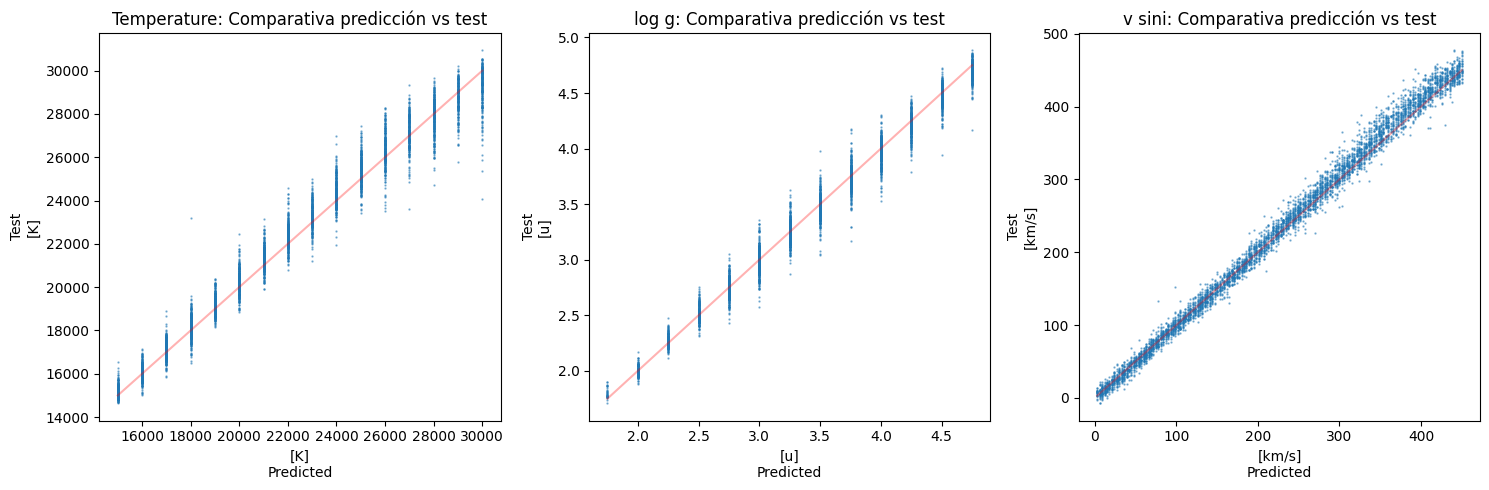

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for i, featureName in enumerate(target):
	x_space = np.linspace(y_scaler.inverse_transform(y_test)[:,i].min(), y_scaler.inverse_transform(y_test)[:,i].max(), 100)
	axes[i].scatter(x=y_scaler.inverse_transform(y_test)[:,i],y=predictions[:,i],s=0.5,alpha=0.5)
	axes[i].plot(x_space,x_space,c='red',alpha=0.3)
	axes[i].set_xlabel(measure_unit[i]+'\nPredicted')
	axes[i].set_ylabel('Test\n'+measure_unit[i])
	axes[i].set_title(measure[i])
 
plt.suptitle('Single Canonical CNN over Unadulterated Test Data Prediction Comparison')
plt.tight_layout();
plt.show()

c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


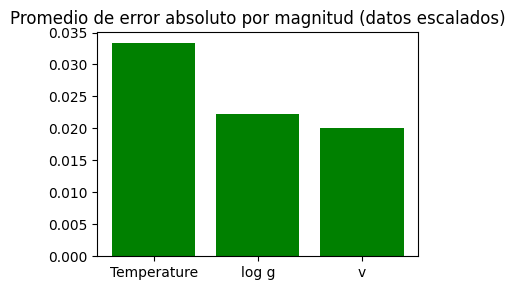

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4,3))
x_data = ['Temperature','log g','v']

diff = np.mean(np.abs(y_scaler.transform(predictions)-y_test),axis=0)
axes.bar(x_data,diff, color='green')
axes.set_title('Promedio de error absoluto por magnitud (datos escalados)')
plt.tight_layout();
plt.show()


## Resultados datos de testing

In [ ]:
#data formatting
inverse_y_test = y_scaler.inverse_transform(y_test)
rel_error = np.abs(predictions-inverse_y_test)*(1/inverse_y_test)*100
abs_error = np.abs(predictions-inverse_y_test)

table_formatted_temperature = [str(round(i)) for i in np.round(inverse_y_test[:,0],0)]
table_formatted_log_g = [str(round(i,2)) for i in np.round(inverse_y_test[:,1],2)]
table_formatted_v = [str(round(i)) for i in np.round(inverse_y_test[:,2],0)]

table_formatted_temperature_pred = [str(round(i)) for i in predictions[:,0]]
table_formatted_log_g_pred = [str(round(i,2)) for i in predictions[:,1]]
table_formatted_v_pred = [str(round(i)) for i in predictions[:,2]]

table_formatted_temperature_error = [str(round(i))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,0],rel_error[:,0])]
table_formatted_log_g_error = [str(round(i,2))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,1],rel_error[:,1])]
table_formatted_v_error = [str(round(i))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,2],rel_error[:,2])]

In [ ]:
# table plot
results = pd.DataFrame({
  'Temperatura':table_formatted_temperature,'Prediccion_Temp':table_formatted_temperature_pred,'Temp_Error_Abs(Rel)':table_formatted_temperature_error,
  'log_g':table_formatted_log_g,'Prediccion_log_g':table_formatted_log_g_pred,'log_g_Error_Abs(Rel)':table_formatted_log_g_error,
  'v':table_formatted_v,'Prediccion_v':table_formatted_v_pred,'v_Error_Abs(Rel)':table_formatted_v_error,

                    })
results.head(20)

,Temperatura,Prediccion_Temp,Temp_Error_Abs(Rel),log_g,Prediccion_log_g,log_g_Error_Abs(Rel),v,Prediccion_v,v_Error_Abs(Rel)
0,28000,26255,1745 (6.2%),2.75,2.58,0.17 (6.3%),156,147,9 (5.5%)
1,27000,27725,725 (2.7%),4.25,4.29,0.04 (0.9%),24,15,9 (36.8%)
2,28000,28623,623 (2.2%),4.5,4.51,0.01 (0.2%),213,208,5 (2.4%)
3,28000,28628,628 (2.2%),4.5,4.51,0.01 (0.1%),36,38,2 (4.4%)
4,16000,15718,282 (1.8%),2.5,2.52,0.02 (0.8%),327,337,10 (3.1%)
5,18000,17775,225 (1.2%),3.25,3.27,0.02 (0.6%),216,206,10 (4.7%)
6,22000,21581,419 (1.9%),3.5,3.36,0.14 (4.0%),54,56,2 (3.5%)
7,21000,21372,372 (1.8%),3.25,3.23,0.02 (0.6%),321,325,4 (1.4%)
8,18000,17775,225 (1.3%),3.75,3.93,0.18 (4.9%),72,64,8 (10.6%)
9,20000,20890,890 (4.5%),4.0,4.0,0.0 (0.1%),138,147,9 (6.9%)


## Datos Observados

In [ ]:
predictions = model.predict(x_obs)

3/3 [==============================] - 0s 102ms/step


In [ ]:
losses = []
maes = []

for i in range(len(target)):
  losses.append(np.mean((predictions[:,i]-y_obs[:,i])**2))
  maes.append(np.mean(np.abs(predictions[:,i]-y_obs[:,i])))
  
print('Temperatura - loss: %.3f  MAE:%.3f'% (losses[0],maes[0]))
print('log g -       loss: %.3f  MAE:%.3f'% (losses[1],maes[1]))
print('v -           loss: %.3f  MAE:%.3f'% (losses[2],maes[2]))


Temperatura - loss: 0.177  MAE:0.321
log g -       loss: 0.219  MAE:0.286
v -           loss: 0.142  MAE:0.320


In [ ]:
predictions = y_scaler.inverse_transform(predictions)

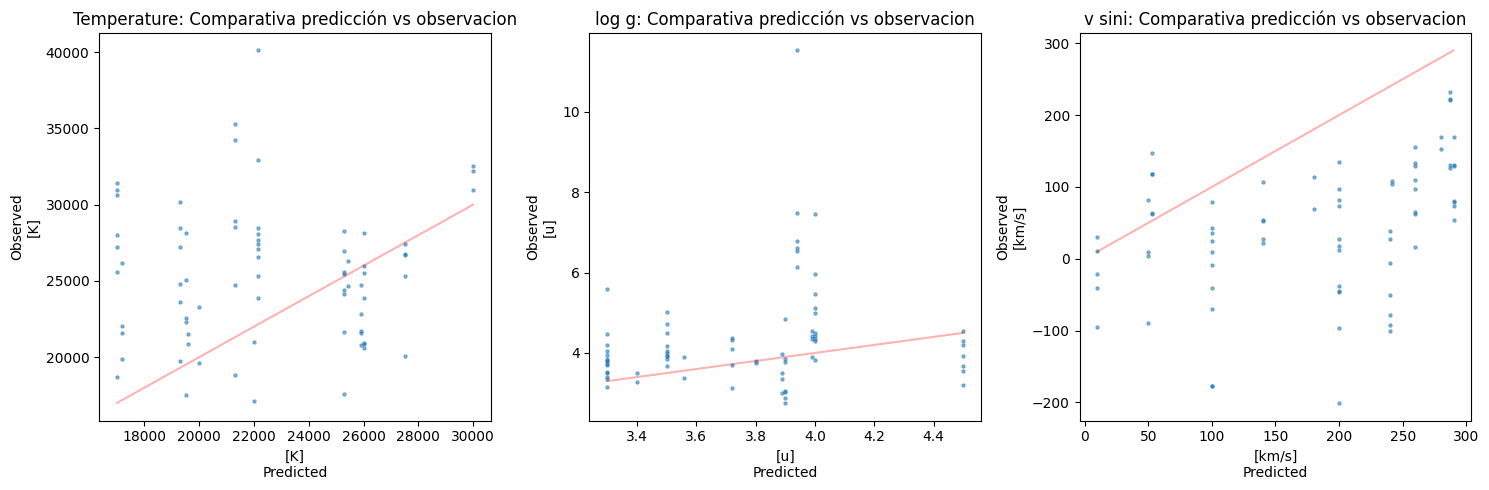

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for i, featureName in enumerate(target):
	x_space = np.linspace(y_scaler.inverse_transform(y_obs)[:,i].min(), y_scaler.inverse_transform(y_obs)[:,i].max(), 100)
	axes[i].scatter(x=y_scaler.inverse_transform(y_obs)[:,i],y=predictions[:,i],s=5,alpha=0.5)
	axes[i].plot(x_space,x_space,c='red',alpha=0.3)
	axes[i].set_xlabel(measure_unit[i]+'\nPredicted')
	axes[i].set_ylabel('Observed\n'+measure_unit[i])
	axes[i].set_title(measure[i]+': Comparativa predicción vs observacion')
 
plt.tight_layout();
plt.show()

In [ ]:
# xi
def xi(obs,sint):
  return np.sum((obs - sint)**2/sint)
def get_closest_spectra_line(index):
  obs = x_obs[index]
  min_dist = np.inf
  min_dist_index = -1
  for i, sint in enumerate(x):
    
    d = xi(obs, sint)
    if d < min_dist:
      min_dist = d
      min_dist_index = i
      
  return min_dist, min_dist_index

In [ ]:
# find closest parameters
import numpy as np
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx
  
nearest = []
for obs_parameters in Y_obs.to_numpy():
	neighbor = []
	for param_index in range(len(target)):
		v, _ = find_nearest(Y.iloc[:,param_index].values,obs_parameters[param_index])
		neighbor.append(v)
	nearest.append(neighbor)
 
nearest_index = []
for neighbor in nearest:
	nearest_index.append(Y[(Y.temperature == neighbor[0]) & (Y.g == neighbor[1]) & (Y.v == neighbor[2])].index[0])

In [ ]:
#data formatting
inverse_y_obs = y_scaler.inverse_transform(y_obs)
rel_error = np.abs(predictions-inverse_y_obs)*(1/inverse_y_obs)*100
abs_error = np.abs(predictions-inverse_y_obs)
#close = np.array([get_closest_spectra_line(index) for index in range(len(X_obs))])[:,0]

table_formatted_temperature = [str(round(i)) for i in np.round(inverse_y_obs[:,0],0)]
table_formatted_log_g = [str(round(i,2)) for i in np.round(inverse_y_obs[:,1],2)]
table_formatted_v = [str(round(i)) for i in np.round(inverse_y_obs[:,2],0)]

table_formatted_temperature_pred = [str(round(i)) for i in predictions[:,0]]
table_formatted_log_g_pred = [str(round(i,2)) for i in predictions[:,1]]
table_formatted_v_pred = [str(round(i)) for i in predictions[:,2]]

table_formatted_temperature_error = [str(round(i))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,0],rel_error[:,0])]
table_formatted_log_g_error = [str(round(i,2))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,1],rel_error[:,1])]
table_formatted_v_error = [str(round(i))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,2],rel_error[:,2])]

# xi es la distancia entre el espectro observado y el espectro sintetico que tiene parámetros más cercanos a la estrella
table_formatted_xi = [xi(obs,sint) for obs, sint in zip(x_obs,X.iloc[nearest_index].to_numpy())]


In [ ]:
# tabla de resultados modelo unico sobre datos observados

results = pd.DataFrame({
  'Temperatura':table_formatted_temperature,'Prediccion_Temp':table_formatted_temperature_pred,'Temp_Error_Abs(Rel)':table_formatted_temperature_error,
  'log_g':table_formatted_log_g,'Prediccion_log_g':table_formatted_log_g_pred,'log_g_Error_Abs(Rel)':table_formatted_log_g_error,
  'v':table_formatted_v,'Prediccion_v':table_formatted_v_pred,'v_Error_Abs(Rel)':table_formatted_v_error,
  'paramCloseXi': table_formatted_xi
                    })
Obs_df[['HD','date','time']].join(results).set_index('HD').head(20)

,date,time,Temperatura,Prediccion_Temp,Temp_Error_Abs(Rel),log_g,Prediccion_log_g,log_g_Error_Abs(Rel),v,Prediccion_v,v_Error_Abs(Rel),paramCloseXi
HD,,,,,,,,,,,,
33328,2012-11-13,05-37-18,19526,28145,8619 (44.1%),3.3,3.53,0.23 (7.0%),287,221,66 (22.8%),120.025827
33328,2013-01-18,03-39-09,19526,25039,5513 (28.2%),3.3,3.35,0.05 (1.4%),287,233,54 (19.0%),126.120582
33328,2013-02-26,00-55-34,19526,22579,3053 (15.6%),3.3,3.41,0.11 (3.2%),287,222,65 (22.5%),128.909122
33328,2015-02-25,23-58-07,19526,22319,2793 (14.3%),3.3,3.7,0.4 (12.0%),287,127,160 (55.9%),137.746389
33328,2015-02-26,00-19-03,19526,17543,1983 (10.2%),3.3,3.95,0.65 (19.8%),287,130,157 (54.5%),145.656198
35165,2014-03-20,23-53-54,17000,31414,14414 (84.8%),4.0,4.31,0.31 (7.6%),240,-92,332 (138.3%),524.359841
35165,2014-03-21,00-14-49,17000,27191,10191 (59.9%),4.0,5.48,1.48 (37.0%),240,-51,291 (121.1%),630.446058
35165,2014-03-21,00-35-18,17000,18719,1719 (10.1%),4.0,7.46,3.46 (86.6%),240,38,202 (84.1%),696.609733
35165,2015-11-14,04-22-43,17000,30985,13985 (82.3%),4.0,4.5,0.5 (12.5%),240,-100,340 (141.8%),608.491193


# 4. Ensemble

In [ ]:
import time
# time meausre
import time
import math
start_time = time.time()

def print_time(execution_time):
    hours = int(math.floor(int(execution_time)/3600))
    minutes = int(math.floor((execution_time/3600-hours)*60))
    seconds = execution_time%60
    print("--- Total: %i hours, %i minutes, %f seconds  ---" % (hours,minutes,seconds))

# set timer
curr_time = time.time()

In [ ]:
from keras.optimizers import Adam
from keras.models import Model

NUM_MODELS = 10
models = [generate_model() for i in range(NUM_MODELS)]
history = []


for i, model in enumerate(models):
	optimizer = Adam()
	model.compile(loss='MSE',optimizer=optimizer)
	history.append(model.fit(x=x_train, y=y_train, epochs=30))

Epoch 1/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0744
Epoch 2/30
459/459 [==============================] - 4s 10ms/step - loss: 0.0336
Epoch 3/30
459/459 [==============================] - 4s 10ms/step - loss: 0.0162
Epoch 4/30
459/459 [==============================] - 4s 10ms/step - loss: 0.0098
Epoch 5/30
459/459 [==============================] - 4s 10ms/step - loss: 0.0072
Epoch 6/30
459/459 [==============================] - 4s 10ms/step - loss: 0.0053
Epoch 7/30
459/459 [==============================] - 4s 10ms/step - loss: 0.0045
Epoch 8/30
459/459 [==============================] - 4s 10ms/step - loss: 0.0041
Epoch 9/30
459/459 [==============================] - 4s 10ms/step - loss: 0.0035
Epoch 10/30
459/459 [==============================] - 4s 10ms/step - loss: 0.0031
Epoch 11/30
459/459 [==============================] - 4s 10ms/step - loss: 0.0031
Epoch 12/30
459/459 [==============================] - 4s 10ms/step - loss: 0.0025
Epoch 13/30
4

In [ ]:
# execution time print
print_time(float(time.time() - curr_time))

--- Total: 0 hours, 23 minutes, 29.424173 seconds  ---


In [ ]:
predictions = np.array([model.predict(x_test) for model in models]) # dim(predictions) = (num_models, num_rows, num_outputs)

153/153 [==============================] - 1s 6ms/step


In [ ]:
weights = [model.evaluate(x_test, y_test) for model in models]
weights = [weight/sum(weights) for weight in weights]

ensemble_prediction = sum([predictions[i]*weights[i] for i in range(len(models))])
uncertainty = sum([(predictions[i]-ensemble_prediction)**2*weights[i] for i in range(len(models))])


153/153 [==============================] - 2s 8ms/step - loss: 0.0015


In [ ]:
# metricas por parametro

losses = []
maes = []

for i in range(len(target)):
  losses.append(np.mean((ensemble_prediction[:,i]-y_test[:,i])**2))
  maes.append(np.mean(np.abs(ensemble_prediction[:,i]-y_test[:,i])))
  
print('Temperatura - loss: %.3f  MAE:%.3f'% (losses[0],maes[0]))
print('log g -       loss: %.3f  MAE:%.3f'% (losses[1],maes[1]))
print('v -           loss: %.3f  MAE:%.3f'% (losses[2],maes[2]))


Temperatura - loss: 0.002  MAE:0.028
log g -       loss: 0.001  MAE:0.019
v -           loss: 0.000  MAE:0.013


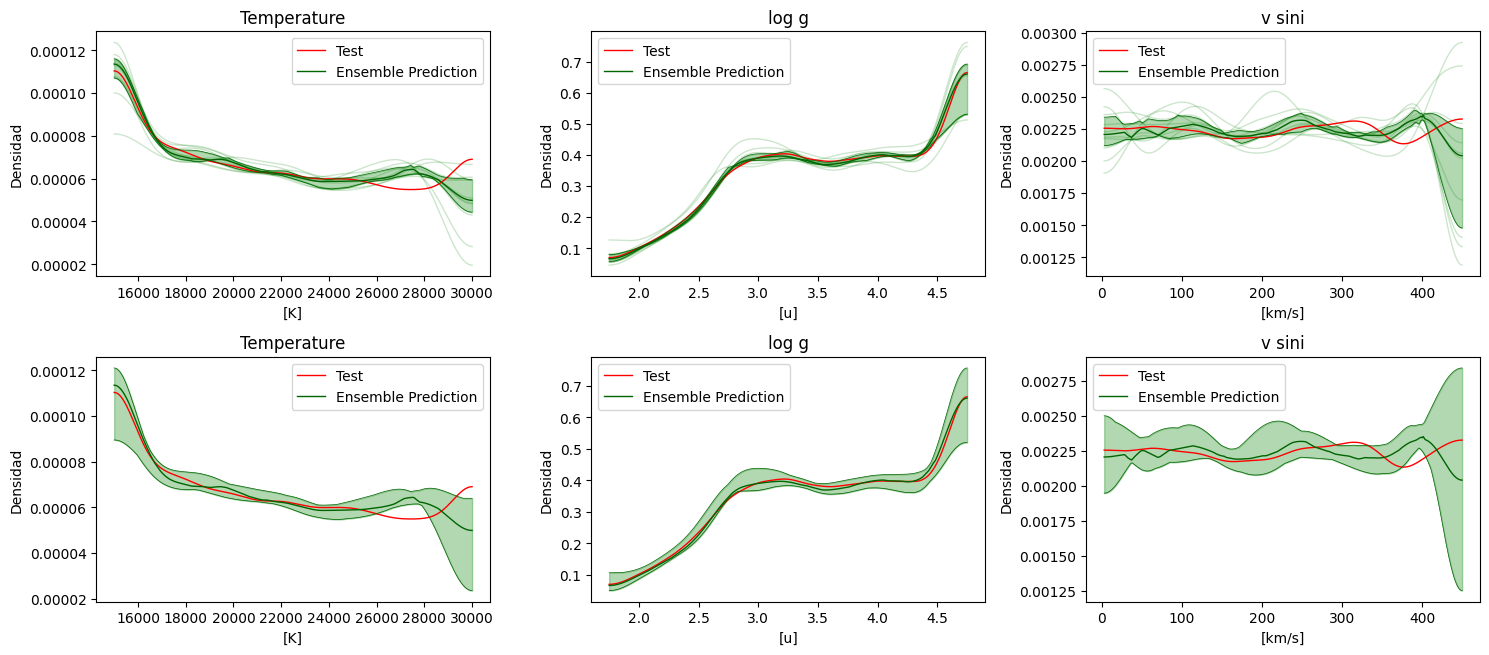

In [ ]:
# Ref: https://stackoverflow.com/questions/60130503/plotting-bars-hist-and-pdf-line-via-kdeplot
import scipy.stats as st
from scipy.interpolate import interp1d

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,6.66))

for i, featureName in enumerate(target):
	x_space = np.linspace(Y[featureName].min(), Y[featureName].max(), 2**12)
	heights = []
	for j in range(NUM_MODELS):
		prediction_y = y_scaler.inverse_transform(predictions[j,:,:]) # your data goes here
		prediction_y = prediction_y[:,i]
		x,y,prediction_kde = SKL_density_plot(prediction_y, axes[0,i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color = 'green',alpha=0.2)
		f = interp1d(x, y, kind="linear", assume_sorted=True)
		h = f(x_space)*3
		heights.append(h)
  
	heights = np.array(heights)
 
	rescaled_y = y_scaler.inverse_transform(y_test)[:,i]
	x,y,test_kde = SKL_density_plot(rescaled_y, axes[0,i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color = 'red',label='Test')
	x,y,test_kde = SKL_density_plot(rescaled_y, axes[1,i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color = 'red',label='Test')
	f = interp1d(x, y, kind="linear", assume_sorted=True)
	test_h = f(x_space)
 
	# cuantiles 50% de los datos
	q25 = np.quantile(heights,0.25,axis=0)
	q75 = np.quantile(heights,0.75,axis=0)
	axes[0,i].plot(x_space, np.median(heights,axis=0),color='darkGreen',alpha=1,linewidth=1,label='Ensemble Prediction')
	axes[0,i].plot(x_space, q25,color='darkGreen',alpha=1,linewidth=0.5)
	axes[0,i].plot(x_space, q75,color='darkGreen',alpha=1,linewidth=0.5)
	axes[0,i].fill_between(x_space, q25,q75, alpha=0.30, color='green')
	
	# cuantiles 95% de los datos
	q5 = np.quantile(heights,0.05,axis=0)
	q95 = np.quantile(heights,0.95,axis=0)
	axes[1,i].plot(x_space, np.median(heights,axis=0),color='darkGreen',alpha=1,linewidth=1,label='Ensemble Prediction')
	axes[1,i].plot(x_space, q5,color='darkGreen',alpha=1,linewidth=0.5)
	axes[1,i].plot(x_space, q95,color='darkGreen',alpha=1,linewidth=0.5)
	axes[1,i].fill_between(x_space, q5,q95, alpha=0.30, color='green')
	
	measure = ['Temperature','log g', 'v sini']
	measure_unit = ['[K]', '[u]', '[km/s]']
	axes[1,i].set_xlabel(measure_unit[i])
	axes[1,i].set_ylabel('Densidad')
	axes[1,i].legend()
	axes[1,i].set_title(measure[i])

	axes[0,i].set_xlabel(measure_unit[i])
	axes[0,i].set_ylabel('Densidad')
	axes[0,i].legend()
	axes[0,i].set_title(measure[i])


plt.tight_layout()
plt.show()

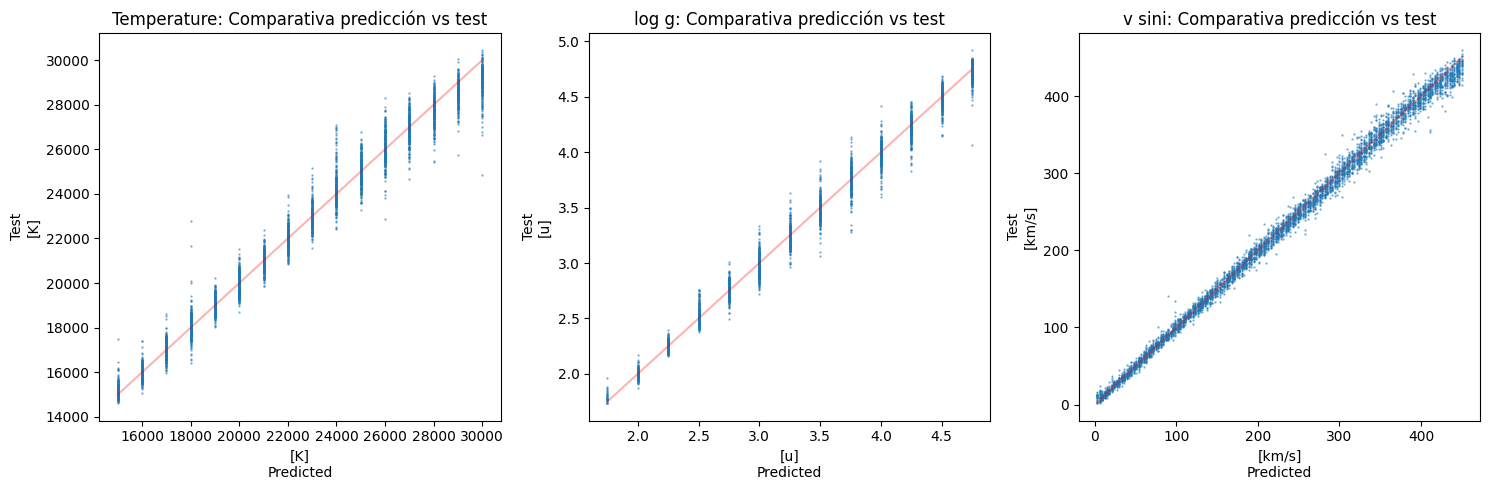

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for i, featureName in enumerate(target):
	x_space = np.linspace(y_scaler.inverse_transform(y_test)[:,i].min(), y_scaler.inverse_transform(y_test)[:,i].max(), 100)
	axes[i].scatter(x=y_scaler.inverse_transform(y_test)[:,i],y=y_scaler.inverse_transform(ensemble_prediction)[:,i],s=0.5,alpha=0.5)
	axes[i].plot(x_space,x_space,c='red',alpha=0.3)
	axes[i].set_xlabel(measure_unit[i]+'\nPredicted')
	axes[i].set_ylabel('Test\n'+measure_unit[i])
	axes[i].set_title(measure[i]+': Comparativa predicción vs test')
 
plt.tight_layout();
plt.show()

# Espectro Observado

In [ ]:
predictions = np.array([model.predict(x_obs) for model in models])

ensemble_prediction = sum([predictions[i]*weights[i] for i in range(NUM_MODELS)])
uncertainty = sum([(ensemble_prediction-predictions[i])**2*weights[i] for i in range(NUM_MODELS)])**(1/2)

3/3 [==============================] - 0s 29ms/step


In [ ]:
# metricas por parametro
losses = []
maes = []

for i in range(len(target)):
  losses.append(np.mean((ensemble_prediction[:,i]-y_obs[:,i])**2))
  maes.append(np.mean(np.abs(ensemble_prediction[:,i]-y_obs[:,i])))
  
print('Temperatura - loss: %.3f  MAE:%.3f'% (losses[0],maes[0]))
print('log g -       loss: %.3f  MAE:%.3f'% (losses[1],maes[1]))
print('v -           loss: %.3f  MAE:%.3f'% (losses[2],maes[2]))


Temperatura - loss: 0.125  MAE:0.290
log g -       loss: 0.262  MAE:0.345
v -           loss: 0.137  MAE:0.311


In [ ]:
ensemble_prediction = y_scaler.inverse_transform(ensemble_prediction)
uncertainty = y_scaler.inverse_transform(uncertainty)

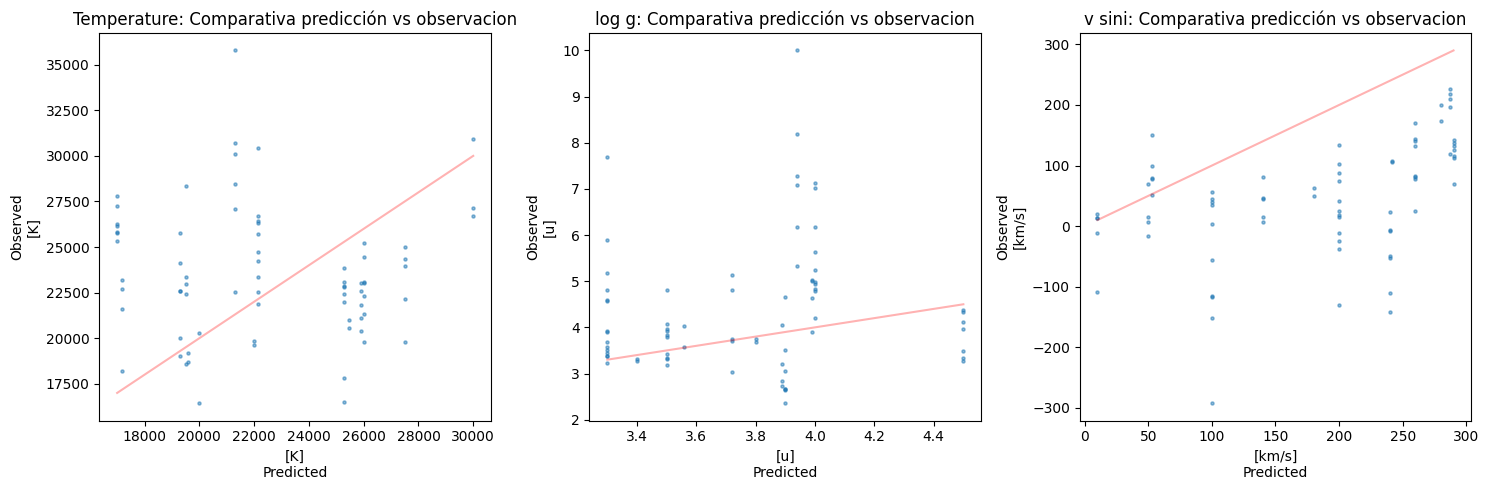

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for i, featureName in enumerate(target):
	x_space = np.linspace(y_scaler.inverse_transform(y_obs)[:,i].min(), y_scaler.inverse_transform(y_obs)[:,i].max(), 100)
	axes[i].scatter(x=y_scaler.inverse_transform(y_obs)[:,i],y=ensemble_prediction[:,i],s=5,alpha=0.5)
	axes[i].plot(x_space,x_space,c='red',alpha=0.3)
	axes[i].set_xlabel(measure_unit[i]+'\nPredicted')
	axes[i].set_ylabel('Observed\n'+measure_unit[i])
	axes[i].set_title(measure[i]+': Comparativa predicción vs observacion')
 
plt.tight_layout();
plt.show()

In [ ]:
# data processing for formatted table

# error sign: ±

table_formatted_temperature_pred = [str(round(i))+' ± '+str(round(j)) for i,j in zip(ensemble_prediction[:,0],uncertainty[:,0])]
table_formatted_log_g_pred = [str(round(i,2))+' ± '+str(round(j,2)) for i,j in zip(ensemble_prediction[:,1],uncertainty[:,1])]
table_formatted_v_pred = [str(round(i))+' ± '+str(round(j)) for i,j in zip(ensemble_prediction[:,2],uncertainty[:,2])]

#data formatting
inverse_y_obs = y_scaler.inverse_transform(y_obs)
rel_error = np.abs(ensemble_prediction-inverse_y_obs)*(1/inverse_y_obs)*100
abs_error = np.abs(ensemble_prediction-inverse_y_obs)

table_formatted_temperature = [str(round(i)) for i in np.round(inverse_y_obs[:,0],0)]
table_formatted_log_g = [str(round(i,2)) for i in np.round(inverse_y_obs[:,1],2)]
table_formatted_v = [str(round(i)) for i in np.round(inverse_y_obs[:,2],0)]

table_formatted_temperature_error = [str(np.round(i))+' ('+str(np.round(j,1))+'%)' for i,j in zip(abs_error[:,0],rel_error[:,0])]
table_formatted_log_g_error = [str(np.round(i,2))+' ('+str(np.round(j,1))+'%)' for i,j in zip(abs_error[:,1],rel_error[:,1])]
table_formatted_v_error = [str(np.round(i))+' ('+str(np.round(j,1))+'%)' for i,j in zip(abs_error[:,2],rel_error[:,2])]

In [ ]:
# dataframe comparativo de datos observados
inverse_y_obs = y_scaler.inverse_transform(y_obs)
results = pd.DataFrame({
  'Temperatura':table_formatted_temperature,'Prediccion_Temperatura':table_formatted_temperature_pred,'Temp_Error_Abs(Rel)':table_formatted_temperature_error,
  'log_g':table_formatted_log_g,'Prediccion_log_g':table_formatted_log_g_pred,'log_g_Error_Abs(Rel)':table_formatted_log_g_error,
  'v':table_formatted_v,'Prediccion_v':table_formatted_v_pred,'v_Error_Abs(Rel)':table_formatted_v_error,
  'paramCloseXi': table_formatted_xi
                    })
Obs_df[['HD','date','time']].join(results).set_index('HD').head(60)

,date,time,Temperatura,Prediccion_Temperatura,Temp_Error_Abs(Rel),log_g,Prediccion_log_g,log_g_Error_Abs(Rel),v,Prediccion_v,v_Error_Abs(Rel),paramCloseXi
HD,,,,,,,,,,,,
33328,2012-11-13,05-37-18,19526,28339 ± 16833,8813.0 (45.1%),3.3,3.44 ± 1.95,0.14 (4.3%),287,219 ± 23,68.0 (23.8%),120.025827
33328,2013-01-18,03-39-09,19526,23360 ± 16937,3834.0 (19.6%),3.3,3.23 ± 1.94,0.07 (2.2%),287,227 ± 21,60.0 (20.9%),126.120582
33328,2013-02-26,00-55-34,19526,22408 ± 17881,2882.0 (14.8%),3.3,3.39 ± 1.92,0.09 (2.7%),287,210 ± 28,77.0 (26.7%),128.909122
33328,2015-02-25,23-58-07,19526,22998 ± 17250,3472.0 (17.8%),3.3,3.51 ± 1.87,0.21 (6.5%),287,196 ± 32,91.0 (31.7%),137.746389
33328,2015-02-26,00-19-03,19526,18570 ± 16705,956.0 (4.9%),3.3,3.69 ± 2.09,0.39 (11.9%),287,120 ± 23,167.0 (58.4%),145.656198
35165,2014-03-20,23-53-54,17000,26258 ± 21005,9258.0 (54.5%),4.0,4.21 ± 2.61,0.21 (5.2%),240,-49 ± 128,289.0 (120.4%),524.359841
35165,2014-03-21,00-14-49,17000,27821 ± 24036,10821.0 (63.7%),4.0,6.18 ± 3.05,2.18 (54.4%),240,-142 ± 139,382.0 (159.1%),630.446058
35165,2014-03-21,00-35-18,17000,25354 ± 26407,8354.0 (49.1%),4.0,7.12 ± 3.31,3.12 (78.1%),240,-110 ± 142,350.0 (146.0%),696.609733
35165,2015-11-14,04-22-43,17000,27247 ± 19195,10247.0 (60.3%),4.0,4.83 ± 2.69,0.83 (20.8%),240,-8 ± 97,248.0 (103.1%),608.491193
